# 02. PyTorch Neural Network Classification
## 0. 分類ニューラルネットワークのアーキテクチャ

|Hyperparameter	|Binary Classification|	Multiclass classification|
|-|-|-|
|Input layer shape (in_features)|	Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction)|	Same as binary classification|
|Hidden layer(s)	|Problem specific, minimum = 1, maximum = unlimited	Same as binary| classification|
|Neurons per hidden layer	|Problem specific, generally 10 to 512	|Same as binary classification|
|Output layer shape (out_features)|	1 (one class or the other)	|1 per class (e.g. 3 for food, person or dog photo)|
|Hidden layer activation|	Usually ReLU (rectified linear unit) but can be many others|	Same as binary classification|
|Output activation	|Sigmoid (torch.sigmoid in PyTorch)	|Softmax (torch.softmax in PyTorch)|
|Loss function|	Binary crossentropy (torch.nn.BCELoss in PyTorch)|	Cross entropy (torch.nn.CrossEntropyLoss in PyTorch)|
|Optimizer|	SGD (stochastic gradient descent), Adam (see torch.optim for more options)	|Same as binary classification|

## 1. Make classification data and get it ready


In [120]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples = n_samples,
                    noise = 0.03,
                    random_state=42)
print(type(X))
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

<class 'numpy.ndarray'>
First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


         X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0
5 -0.479646  0.676435      1
6 -0.013648  0.803349      1
7  0.771513  0.147760      1
8 -0.169322 -0.793456      1
9 -0.121486  1.021509      0


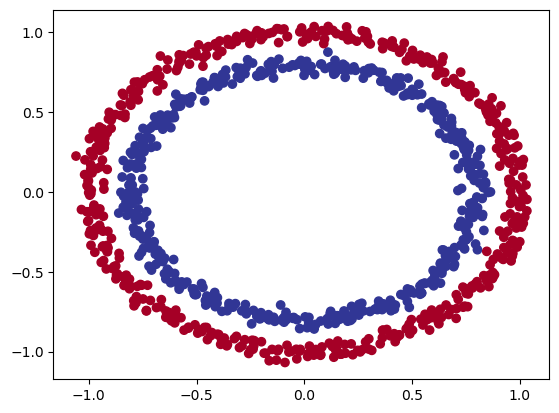

In [121]:
# make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y})
print(circles.head(10))

# Visualizer
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 check input and output shapes

In [122]:
print(X.shape, y.shape)
print(type(X))

# view the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

(1000, 2) (1000,)
<class 'numpy.ndarray'>
Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 turn data into tensors and create train and test splits

In [123]:
# turn data into tensors
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

print(X[0],y[0])

# split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print(X_test.shape, y_test.shape)
print(X_train[:5], y_train[:5])
len(X_train),len(X_test),len(y_train),len(y_test)

tensor([0.7542, 0.2315]) tensor(1.)
torch.Size([200, 2]) torch.Size([200])
tensor([[-0.5945,  0.5481],
        [-0.4160,  0.7137],
        [-0.7646, -0.2763],
        [ 0.6387,  0.5345],
        [ 0.8572, -0.5925]]) tensor([1., 1., 1., 1., 0.])


(800, 200, 800, 200)

## 2.build a model
データの準備ができたので、次はモデルを構築します。

いくつかの部分に分けて説明します。

1. デバイスに依存しないコードを設定する (そのため、モデルが使用可能な場合は CPU または GPU で実行できます)。
2. nn.モジュール。
3. 損失関数とオプティマイザの定義。
4. トレーニングループの作成(これについては次のセクションで説明します)。

In [124]:
from torch import nn

# device
device = "mps" if torch.mps.is_available() else "cpu"

Let's create a model class that:

1. Subclasses nn.Module (almost all PyTorch models are subclasses of nn.Module).
2. Creates 2 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.
3. Defines a forward() method containing the forward pass computation of the model.
4. Instantiates the model class and sends it to the target device.

In [125]:
# 1. contstrict a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. create 2 nn.Linear layers capable of handling the shapes of our data
        # takes in 2 features (X), produces 5 features
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        # takes in 5 features, produces 1 feature (y)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
        # self.two_linear_layer = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )
    # 3. define a forward() method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
        # return self.two_linear_layer(x)

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device=device)
next(model_0.parameters()).device


device(type='mps', index=0)

In [126]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.ReLU(),
    nn.Linear(in_features=5, out_features=1)
).to(device=device)
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2976,  0.6313],
                      [ 0.4087, -0.3091],
                      [ 0.4082,  0.1265],
                      [ 0.3591, -0.4310],
                      [-0.7000, -0.2732]], device='mps:0')),
             ('0.bias',
              tensor([-0.5424,  0.5802,  0.2037,  0.2929,  0.2236], device='mps:0')),
             ('2.weight',
              tensor([[-0.0078,  0.3500, -0.3178,  0.0282, -0.3052]], device='mps:0')),
             ('2.bias', tensor([0.1379], device='mps:0'))])

In [127]:
# make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, shape: {untrained_preds.shape}")
print(f"Length of test sample: {len(X_test)}, shape: {X_test.shape}")
print(f"First 10 predictions: {untrained_preds[:10]}")
print(f"First 10 labels: {y_test[:10]}")

Length of predictions: 200, shape: torch.Size([200, 1])
Length of test sample: 200, shape: torch.Size([200, 2])
First 10 predictions: tensor([[ 0.3639],
        [ 0.1690],
        [ 0.4165],
        [ 0.2865],
        [ 0.1603],
        [ 0.0203],
        [ 0.0058],
        [-0.0157],
        [-0.0180],
        [ 0.1476]], device='mps:0')
First 10 labels: tensor([1., 1., 0., 1., 1., 1., 0., 1., 1., 0.])


### 2.1 setup loss fuction and optimizer
以前にノートブック01で損失(基準またはコスト関数とも呼ばれます)とオプティマイザーを設定しました。

しかし、問題の種類が異なれば、必要な損失関数も異なります。

たとえば、回帰問題 (数値の予測) では、平均絶対誤差 (MAE) 損失を使用できます。

また、バイナリ分類の問題では、損失関数としてバイナリ クロス エントロピーを使用することがよくあります。

ただし、多くの場合、同じオプティマイザー関数を異なる問題空間で使用できます。

たとえば、確率的勾配降下オプティマイザー (SGD, torch.optim.SGD()) はさまざまな問題に使用できますが、Adam オプティマイザー (torch.optim.Adam()) も同様です。

|Loss function/Optimizer	|Problem type	|PyTorch Code|
|-|-|-|
|Stochastic Gradient Descent (SGD) optimizer	|Classification, regression, many others.	|torch.optim.SGD()|
|Adam Optimizer	|Classification, regression, many others.	|torch.optim.Adam()
|Binary cross entropy loss	|Binary classification	|torch.nn.BCELossWithLogits or torch.nn.BCELoss
|Cross entropy loss	|Multi-class classification	|torch.nn.CrossEntropyLoss|
|Mean absolute error (MAE) or L1 Loss	|Regression	|torch.nn.L1Loss|
|Mean squared error (MSE) or L2 Loss	|Regression	|torch.nn.MSELoss|

PyTorch には、2 つのバイナリ クロス エントロピー実装があります。

* `torch.nn.BCELoss()` - ターゲット (ラベル) と入力 (特徴) の間のバイナリ クロス エントロピーを測定する損失関数を作成します。
* `torch.nn.BCEWithLogitsLoss()` - これは上記と同じですが、シグモイド層 (nn.Sigmoid) が組み込まれています (これが何を意味するかはすぐにわかります)。

どちらを使うべきですか?

`torch.nn.BCEWithLogitsLoss()` のドキュメンテーションには、nn の後に `torch.nn.BCELoss()` を使用するよりも数値的に安定していると記載されています。シグモイド層。

したがって、一般的には、実装 2 の方が適しています。ただし、高度な使用法では、`nn.Sigmoid()` と `torch.nn.BCELoss()` の組み合わせを分離することをお勧めします。それはこのノートブックの範囲を超えています。

これを知って、損失関数とオプティマイザを作成しましょう。

オプティマイザでは、torch.optim.SGD() を使用して、学習率 0.1 でモデルパラメータを最適化します。

In [128]:
# create a loss function
# loss_fn = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

# calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## 3. Train model

**PyTorch training loop steps**
1. **Forward pass** - The model goes through all of the training data once, performing its forward() function calculations (model(x_train)).

2. **Calculate the loss** - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (loss = loss_fn(y_pred, y_train).

3. **Zero gradients** - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (optimizer.zero_grad()).

4. **Perform backpropagation on the loss** - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards" (loss.backward()).

5. **Step the optimizer (gradient descent)** - Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them (optimizer.step()).

### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [129]:
# view the first 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.3639],
        [0.1690],
        [0.4165],
        [0.2865],
        [0.1603]], device='mps:0', grad_fn=<SliceBackward0>)

In [130]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
print(y_test[:5], torch.round(y_pred_probs))

# find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([1., 1., 0., 1., 1.]) tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='mps:0', grad_fn=<RoundBackward0>)
tensor([True, True, True, True, True], device='mps:0')


tensor([1., 1., 1., 1., 1.], device='mps:0', grad_fn=<SqueezeBackward0>)

### 3.2 トレーニングとテストのループを構築する

In [131]:
torch.mps.manual_seed(42)

# set the number of epchos
epochs = 1000

# put data to target device
X_train, X_test =X_train.to(device), X_test.to(device)
y_train, y_test =y_train.to(device), y_test.to(device)

# build training and evaluation loop
for epoch in range(epochs):
    # traning
    model_0.train()
    # 1. forward pass
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    # 2.calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)

    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_preds)
    # 3. optimizer zero grad
    optimizer.zero_grad()
    # 4.loss backward
    loss.backward()
    # 5 .optimizer step
    optimizer.step()

    # testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_preds)
    
    # print out
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69555, Accuracy: 56.62% | Test loss: 0.68961, Test acc: 54.00%
Epoch: 100 | Loss: 0.68488, Accuracy: 57.00% | Test loss: 0.68687, Test acc: 53.00%
Epoch: 200 | Loss: 0.68111, Accuracy: 57.50% | Test loss: 0.68388, Test acc: 54.50%
Epoch: 300 | Loss: 0.67678, Accuracy: 58.13% | Test loss: 0.68012, Test acc: 53.50%
Epoch: 400 | Loss: 0.67158, Accuracy: 59.25% | Test loss: 0.67569, Test acc: 54.50%
Epoch: 500 | Loss: 0.66526, Accuracy: 60.25% | Test loss: 0.66991, Test acc: 56.00%
Epoch: 600 | Loss: 0.65724, Accuracy: 62.12% | Test loss: 0.66266, Test acc: 56.00%
Epoch: 700 | Loss: 0.64689, Accuracy: 65.25% | Test loss: 0.65343, Test acc: 58.50%
Epoch: 800 | Loss: 0.63465, Accuracy: 72.38% | Test loss: 0.64152, Test acc: 66.00%
Epoch: 900 | Loss: 0.62025, Accuracy: 82.38% | Test loss: 0.62660, Test acc: 75.50%


## 4. 予測を行い、モデルを評価する


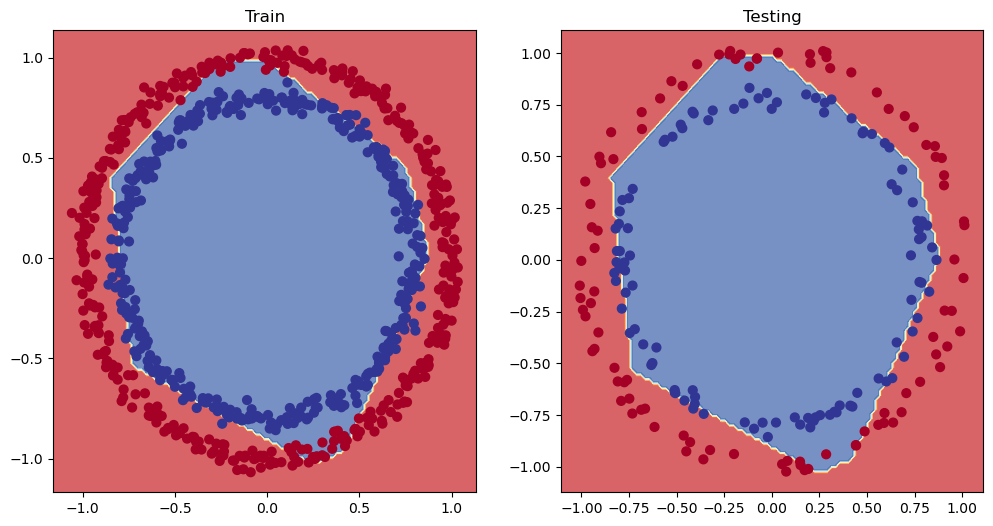

In [132]:
from helper_functions import plot_predictions, plot_decision_boundary

# plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing")
plot_decision_boundary(model_0, X_test, y_test)

## 5. モデルの改善(モデルの観点から)
モデルのアンダーフィットの問題を修正してみましょう。

特にモデル(データではない)に焦点を当てると、これを行う方法はいくつかあります。

|モデル改善手法*	|それは何をしますか?|
|-|-|
|レイヤーを追加	|各レイヤーは、データ内の何らかの新しいパターンを学習できるようにすることで、モデルの学習能力を向上させる可能性があります。レイヤーが増えると、ニューラルネットワークが深くなるとよく言われます。|
|非表示のユニットをさらに追加する|	上記と同様に、レイヤーあたりの隠れユニットが多いほど、モデルの学習能力が向上する可能性があります。隠れユニットが増えると、ニューラルネットワークが広くなるとよく言われます。|
|より長い(より多くのエポック)のフィッティング	|モデルがデータを見る機会が多ければ多いほど、モデルはより多くを学習する可能性があります。|
|アクティベーション機能の変更|	一部のデータは直線だけでは適合しません(私たちが見たもののように)、非線形活性化関数を使用するとこれに役立ちます(ヒント、ヒント)。|
|学習率を変更する|	モデル固有ではありませんが、それでも関連性があるため、オプティマイザーの学習率は、モデルが各ステップでパラメーターをどの程度変更すべきかを決定します。多すぎるとモデルが過剰に修正し、少なすぎて十分に学習しません。|
|損失関数を変更する|	繰り返しになりますが、モデルに固有ではありませんが、それでも重要な問題が異なれば、必要な損失関数も異なります。たとえば、バイナリ クロス エントロピー損失関数は、多クラス分類問題では機能しません。|
|転移学習を使用する	|自分と類似した問題領域から事前学習済みモデルを取得し、それを自分の問題に合わせて調整します。転移学習については、ノートブック06で説明します。|

モデルにレイヤーを追加し、より長くフィットし(epochs=100ではなくepochs=1000)、隠れユニットの数を5から10に増やすとどうなるか見てみましょう。

上記と同じ手順に従いますが、ハイパーパラメータをいくつか変更します。

In [133]:
class CircleModelV1(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)

    def forward(self,x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [134]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(model_1.parameters(),0.1)
torch.manual_seed(42)
torch.mps.manual_seed(42)

# set the number of epchos
epochs = 1000

# put data to target device
X_train, X_test =X_train.to(device), X_test.to(device)
y_train, y_test =y_train.to(device), y_test.to(device)

# build training and evaluation loop
for epoch in range(epochs):
    # traning
    model_1.train()
    # 1. forward pass
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    # 2.calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)

    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_preds)
    # 3. optimizer zero grad
    optimizer.zero_grad()
    # 4.loss backward
    loss.backward()
    # 5 .optimizer step
    optimizer.step()

    # testing
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_preds)
    
    # print out
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71811, Accuracy: 50.50% | Test loss: 0.72682, Test acc: 48.00%
Epoch: 100 | Loss: 0.69348, Accuracy: 49.50% | Test loss: 0.69462, Test acc: 45.50%
Epoch: 200 | Loss: 0.69311, Accuracy: 47.62% | Test loss: 0.69401, Test acc: 44.50%
Epoch: 300 | Loss: 0.69307, Accuracy: 43.12% | Test loss: 0.69389, Test acc: 43.00%
Epoch: 400 | Loss: 0.69307, Accuracy: 41.25% | Test loss: 0.69385, Test acc: 40.50%
Epoch: 500 | Loss: 0.69307, Accuracy: 41.62% | Test loss: 0.69384, Test acc: 40.50%
Epoch: 600 | Loss: 0.69307, Accuracy: 41.62% | Test loss: 0.69383, Test acc: 40.50%
Epoch: 700 | Loss: 0.69307, Accuracy: 41.88% | Test loss: 0.69383, Test acc: 40.50%
Epoch: 800 | Loss: 0.69307, Accuracy: 41.88% | Test loss: 0.69383, Test acc: 40.00%
Epoch: 900 | Loss: 0.69307, Accuracy: 41.88% | Test loss: 0.69383, Test acc: 40.00%


### 5.1 Preparing data to see if our model can model a straight line
線形データを作成して、モデルがそれをモデル化できるかどうか、そして何も学習できないモデルだけを使用しているのではないかどうかを確認しましょう。

In [135]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [136]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))

80 80 20 20


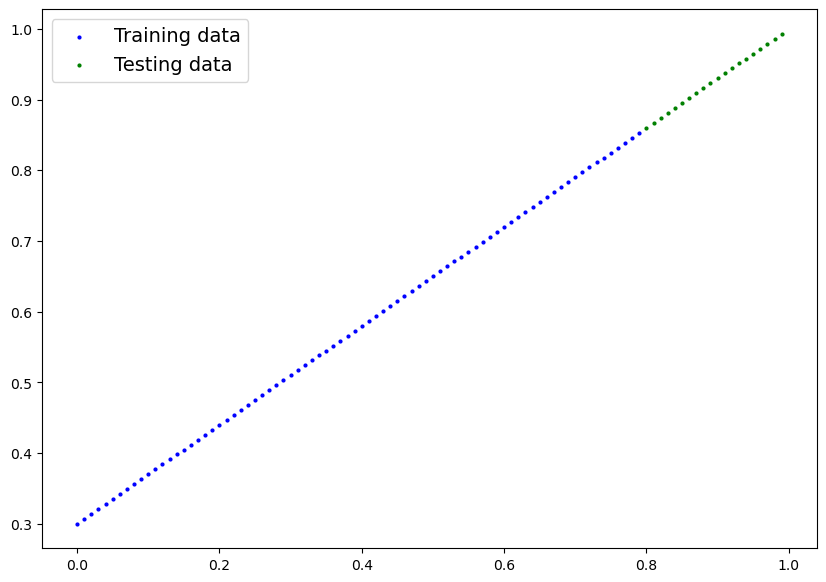

In [137]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
)

In [138]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [139]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [140]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training 
    # 1. Forward pass
    y_pred = model_2(X_train_regression)
    
    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss 
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05599, Test loss: 0.01426
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


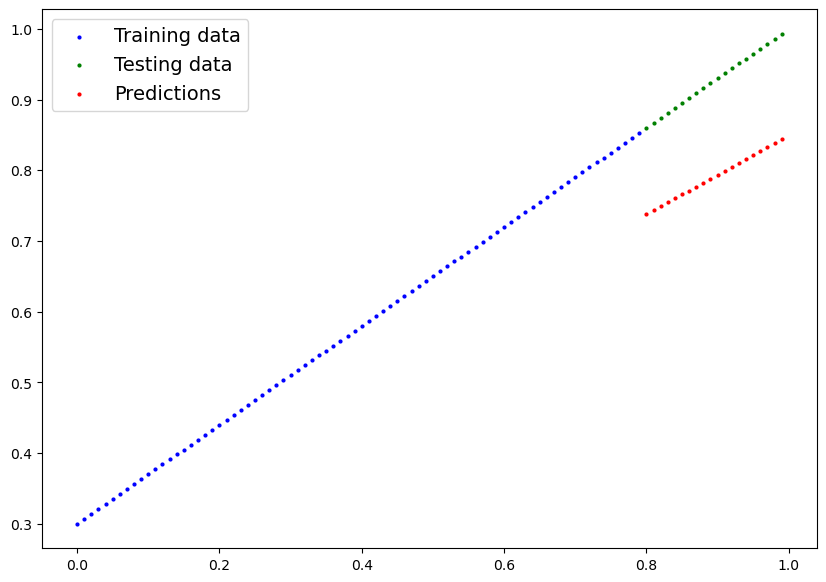

In [141]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## 6. 欠けている部分:非線形性
私たちのモデルは、その線形レイヤーのおかげで、直線(線形)線を描画できることがわかりました。
### 6.1 非線形データ(赤と青の円)の再作成
まず、データを再作成して、新しいデータを開始しましょう。以前と同じセットアップを使用します。

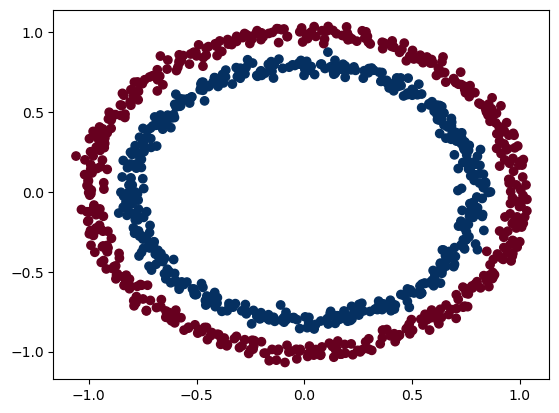

In [142]:
# make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_sample = 1000
X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdBu)

In [143]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 非線形性を持つモデルの構築
PyTorch には、似て非なる動作をする既製の非線形活性化関数が多数あります。

最も一般的でパフォーマンスの高いものの 1 つは ReLU です。整流線形ユニット、torch.nn.ReLU()。

In [144]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.relu = nn.ReLU()
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.layer_1(x))))

model_3 = CircleModelV2().to(device)
model_3



CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (relu): ReLU()
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

先ほど構築したものと同様の分類ニューラルネットワーク(ReLUアクティベーションを使用)がどのようなものかを示す視覚的な例。[TensorFlow Playground のウェブサイト](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.1&regularizationRate=0&noise=5&networkShape=5,5&seed=0.31263&showTestData=false&discretize=false&percTrainData=20&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)で独自のものを作成してみてください。

In [145]:
# setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),0.01)

In [146]:
# fit the model
torch.manual_seed(42)
torch.mps.manual_seed(42)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_3.train()
    y_logits = model_3(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_preds)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        loss = loss_fn(test_logits, y_test)
        acc = accuracy_fn(y_true=y_test,
                          y_pred=test_preds)
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69876, Accuracy: 50.00% | Test Loss: 0.13566, Test Accuracy: 40.00%
Epoch: 100 | Loss: 0.69765, Accuracy: 49.50% | Test Loss: 0.13566, Test Accuracy: 40.00%
Epoch: 200 | Loss: 0.69705, Accuracy: 49.50% | Test Loss: 0.13566, Test Accuracy: 40.00%
Epoch: 300 | Loss: 0.69658, Accuracy: 48.50% | Test Loss: 0.13566, Test Accuracy: 40.00%
Epoch: 400 | Loss: 0.69613, Accuracy: 47.50% | Test Loss: 0.13566, Test Accuracy: 40.00%
Epoch: 500 | Loss: 0.69580, Accuracy: 48.00% | Test Loss: 0.13566, Test Accuracy: 40.00%
Epoch: 600 | Loss: 0.69553, Accuracy: 48.00% | Test Loss: 0.13566, Test Accuracy: 40.00%
Epoch: 700 | Loss: 0.69522, Accuracy: 47.00% | Test Loss: 0.13566, Test Accuracy: 40.00%
Epoch: 800 | Loss: 0.69491, Accuracy: 48.00% | Test Loss: 0.13566, Test Accuracy: 40.00%
Epoch: 900 | Loss: 0.69457, Accuracy: 47.50% | Test Loss: 0.13566, Test Accuracy: 40.00%


### 6.4 非線形活性化関数で学習したモデルの評価

In [147]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
model_3.eval()
with torch.inference_mode():
    y_logits = model_3(X_test).squeeze()
    y_sigmoid = torch.sigmoid(y_logits)
    y_preds = torch.round(y_sigmoid).squeeze()

print(y_logits[:10], end=None)
print(y_sigmoid[:10],end=None)
print(y_preds[:10],end=None)
print(y_test[:10])

tensor([ 0.0579,  0.0834, -0.0096,  0.0914, -0.0713, -0.0642,  0.0245, -0.0113,
        -0.0082,  0.0840], device='mps:0')
tensor([0.5145, 0.5208, 0.4976, 0.5228, 0.4822, 0.4840, 0.5061, 0.4972, 0.4979,
        0.5210], device='mps:0')
tensor([1., 1., 0., 1., 0., 0., 1., 0., 0., 1.], device='mps:0')
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0')


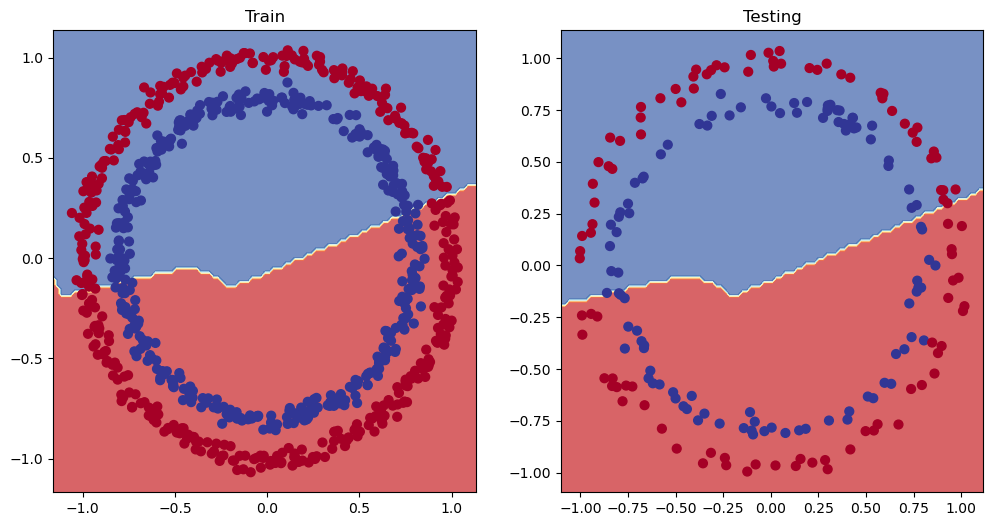

In [148]:
from helper_functions import plot_predictions, plot_decision_boundary

# plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing")
plot_decision_boundary(model_3, X_test, y_test)

## 8. Putting things together by building a multi-class PyTorch model

二項分類の問題は、何かを2つのオプション(たとえば、写真を猫の写真または犬の写真)のいずれかとして分類することを扱いますが、マルチクラス分類問題は、2つ以上のオプションのリストから何かを分類すること(たとえば、写真を猫、犬、または鶏として分類する)を扱います。

### 8.1 Createing a toy multi-class dataset

多クラス分類の問題を開始するために、多クラスデータを作成しましょう。

そのために、Scikit-Learnのmake_blobs()メソッドを活用できます。

このメソッドは、必要な数のクラスを作成します(centersパラメータを使用)。

具体的には、次のことを行いましょう。

1. make_blobs() を使用してマルチクラスデータを作成します。
2. データをテンソルに変換します (デフォルトの make_blobs() は NumPy 配列を使用します)。
3. train_test_split() を使用して、データを学習セットとテスト セットに分割します。
4. データを視覚化します。

tensor([[ 4.6675,  4.4878],
        [-7.9969,  6.8803],
        [-6.2801, -7.8571],
        [ 3.6833,  1.1767],
        [-0.1404, 10.1654]])


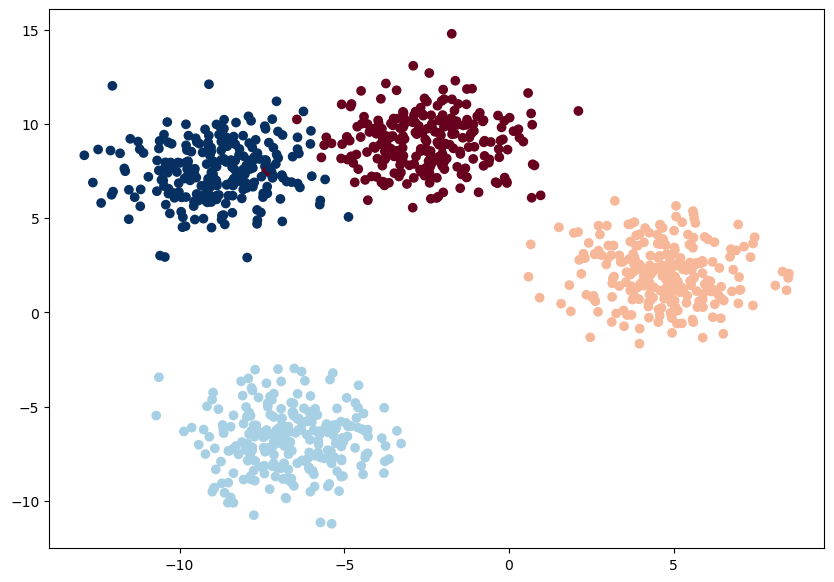

In [149]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,# give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# 3. split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

print(X_blob_test[:5])
# plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdBu)


### 8.2 Building a multi-class classification model in PyTorch


In [150]:
import torch

device = "mps" if torch.mps.is_available() else "cpu"

In [151]:
# build model
from torch import nn
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

# create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device=device)
model_4


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [152]:
# create a loss function for mutil-class classification
loss_fn = nn.CrossEntropyLoss()
# create optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In [153]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))[:5]

print(y_logits, end=None)
print(y_blob_test[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='mps:0')
tensor([1., 3., 2., 1., 0.])


現在、モデルはロジットを出力していますが、サンプルを提供しているラベルを正確に把握したい場合はどうでしょうか。

つまり、二項分類の問題と同じように、どのようにして脱 logits -> prediction probabilities -> prediction labels 却するのでしょうか?

そこで、ソフトマックス活性化関数の出番です。

ソフトマックス関数は、各予測クラスが実際の予測クラスである確率を、他のすべての可能なクラスと比較して計算します。

In [154]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5],end=None)
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='mps:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='mps:0')


ソフトマックス関数の出力は、まだごちゃごちゃした数値のように見えるかもしれませんが(私たちのモデルはトレーニングされておらず、ランダムなパターンを使用して予測しているため、ごちゃごちゃしています)、各サンプルには非常に具体的な違いがあります。

ロジットをソフトマックス関数に通した後、個々のサンプルは 1 (または非常に近い) に加算されます。

確認してみましょう。

In [155]:
# Sum the first sample output of the softmax activation function 
print(y_pred_probs[0])
print(torch.sum(y_pred_probs[0]))
print(torch.max(y_pred_probs[0]))
print(torch.argmax(y_pred_probs[0]))

tensor([0.3169, 0.3244, 0.1405, 0.2182], device='mps:0')
tensor(1., device='mps:0')
tensor(0.3244, device='mps:0')
tensor(1, device='mps:0')


### 8.5 Creating a training and testing loop for a multi-class PyTorch model

In [156]:


torch.manual_seed(42)
torch.mps.manual_seed(42)

# create a loss function for mutil-class classification
loss_fn = nn.CrossEntropyLoss()
# create optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

# set number of epochs
epochs = 100

# put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, test_pred)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=test_pred)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")
    

Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.04937, Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.65776, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24478, Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test Loss: 0.10153, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test Loss: 0.05737, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test Loss: 0.04157, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test Loss: 0.03341, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.02806, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.02425, Test Acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [157]:
# make predictions
model_4.eval()

with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_pred_probs = torch.softmax(y_logits[:10],dim=1)
print(y_pred_probs)
print(y_pred_probs.argmax(dim=1))
print(y_blob_test[:10].type(torch.LongTensor))

tensor([[1.3437e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1955e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2377e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5997e-05, 2.7210e-04]], device='mps:0')
tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')
tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])


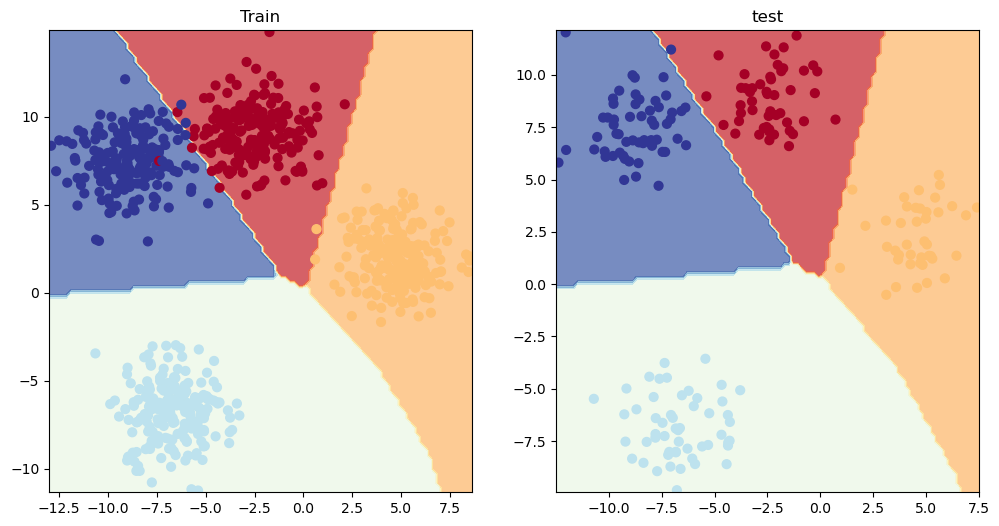

In [158]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. More classification evaluation metrics
これまでは、分類モデルを評価するいくつかの方法 (精度、損失、予測の視覚化) についてのみ説明してきました。

これらは、最も一般的な方法の一部であり、出発点として適しています。

ただし、次のようなより多くのメトリクスを使用して分類モデルを評価することもできます。

|Metric name/Evaluation method	|Defintion	|Code|
|-|-|-|
|Accuracy	|Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct.	|torchmetrics.Accuracy() or sklearn.metrics.accuracy_score()|
|Precision	|Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).	|torchmetrics.Precision() or sklearn.metrics.precision_score()|
|Recall	|Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.	|torchmetrics.Recall() or sklearn.metrics.recall_score()|
|F1-score	|Combines precision and recall into one metric. 1 is best, 0 is worst.|	torchmetrics.F1Score() or sklearn.metrics.f1_score()
|Confusion matrix	|Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line).	|torchmetrics.ConfusionMatrix or sklearn.metrics.plot_confusion_matrix()|
|Classification report	|Collection of some of the main classification metrics such as precision, recall and f1-score.	|sklearn.metrics.classification_report()|



